# Setup

In [1]:
import sys
import os
import dlib
import glob
import time

import cv2
import os

import matplotlib.pyplot as plt

from face_classifier import FaceClassifier

import random
import torch
import numpy as np

import calc
import icio
import postproc

print(dlib.DLIB_USE_CUDA)
print(cv2.__version__)

True
4.5.5


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(79)

In [3]:
# Activating gpu
import face_recognition

def check_use_gpu(TARGET_IMG_PATH):
    image = face_recognition.load_image_file(TARGET_IMG_PATH)
    face_locations = face_recognition.face_locations(image,model='cnn')
    if len(face_locations) > 0:
        print('Using GPU')
    else:
        print('***Not using GPU***')

person_img = "/opt/ml/person-clustering/test.jpg" # person image
check_use_gpu(person_img)

Using GPU


# Extract frame from video and save as images

In [4]:
video_paths = {
    0: "/opt/ml/project/test_videos/giha_before_13m.mp4",
}

In [5]:
file_num = 0

filepath = video_paths[file_num]
video = cv2.VideoCapture(filepath)

assert video.isOpened(), f"Could not Open : {filepath}"

In [6]:
# 불러온 비디오 파일의 정보 출력
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 19153
width : 1280
height : 720
fps : 23.999999665848698


In [7]:
# 변수 설정
frame_batch_size = 16
face_cloth_weights = [1.0, 1.0]
capture_interval = 3 * int(round(fps)) # n초 간격 프레임 캡쳐
stop = 0 # 0 초과의 정수 지정 시 n 초 까지만 영상 실행
skip = 0 # 초반 n 초 skip
face_cnt = 350 # 몇 장의 인물 사진을 사용할 지
resizing_ratio = None # frame resizing ratio (0.0 ~ 1.0)
resizing_resolution = 1000 # 해당 값 이상의 해상도(너비)를 가지는 영상에 대해 resizing 적용
result_dir = filepath[:-4] + '_result_images_face_cloth' # 결과가 저장될 디렉토리

In [8]:
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print('Error: Creaing directory. ' + result_dir)

In [9]:
video = cv2.VideoCapture(filepath) 

# FaceClssifier
fc = FaceClassifier(result_dir)

fingerprints = dict()

frames = []
frame_idx = 0

running = True

# Scene Detection
use_scene_transition = False

last_down_frame = None
last_org_frame = None
        
start_frame_idx = 0
start_down_frame = None
start_org_frame = None
min_scene_frames = 15
timelines = []
down_scale_factor = 8
transition_threshold = 100


total_start = time.time()
while running:
    ret, frame = video.read()

    if frame is None:
        break

    seconds = int(round(frame_idx / fps, 3))
    # print(f"Running in {seconds} sec in video...")
    if seconds > stop > 0:
        break
    if seconds < skip:
        frame_idx += 1
        continue

    ###### Frame extraction ######
    if use_scene_transition:
        cur_down_frame = frame[::down_scale_factor, ::down_scale_factor, :]
                
        if last_down_frame is None:
            last_down_frame = cur_down_frame
            last_org_frame = frame
            start_frame_idx = frame_idx
            start_down_frame = cur_down_frame
            start_org_frame = frame
            frame_idx += 1
            continue
                    
        num_pixels = cur_down_frame.shape[0] * cur_down_frame.shape[1]
        rgb_distance = np.abs(cur_down_frame - last_down_frame) / float(num_pixels)
        rgb_distance = rgb_distance.sum() / 3.0
                
        if rgb_distance > transition_threshold and frame_idx - start_frame_idx > min_scene_frames:
            # print("({}~{})".format(start_frame_idx, frame_idx-1))  
            # resize frame
            if resizing_ratio and frame.shape[1] >= resizing_resolution:
                start_org_frame = cv2.resize(start_org_frame, None, fx=resizing_ratio, fy=resizing_ratio)
                last_org_frame = cv2.resize(last_org_frame, None, fx=resizing_ratio, fy=resizing_ratio)      
            frames.append(start_org_frame)
            frames.append(last_org_frame)
                    
            start_frame_idx = frame_idx
            start_down_frame = cur_down_frame
            start_org_frame = frame
                
        last_down_frame = cur_down_frame
        last_org_frame = frame
    else:
        if frame_idx % capture_interval == 0:
            # resize frame
            if resizing_ratio and frame.shape[1] >= resizing_resolution:
                frame = cv2.resize(frame, None, fx=resizing_ratio, fy=resizing_ratio)
            frames.append(frame)
            
    ###### detect_faces ######
    if len(frames) < frame_batch_size:
        frame_idx += 1
        continue        
    else:
        frame_fingerprints = fc.detect_faces(frames, frame_batch_size, face_cloth_weights)
        if frame_fingerprints:
            fingerprints.update(frame_fingerprints)
            print('# of face images: ', len(fingerprints))
            print('# of frames: ', frame_idx)
            print()   
        frames = []
    
    ###### finish loop ######
    if len(fingerprints) >= face_cnt:
        break
    
    frame_idx += 1


running = False
video.release()
print()

total_end = time.time()
print('Inference time: ',total_end-total_start)
print("Captured frames : ", frame_idx)

image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/20220612_152518.842-0.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/20220612_152518.842-1.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/20220612_152518.842-2.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/20220612_152518.842-3.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/20220612_152518.842-4.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/20220612_152518.842-5.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/20220612_152518.842-6.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/20220612_152518.842-7.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/

# Clustering

#images : #clusters
4 : 5
5 : 3
6 : 3
7 : 1
8 : 2
10 : 1
12 : 1
13 : 2
25 : 1
27 : 1
#images in clusters total:  176
cluster dir: /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/imagecluster/clusters
plot array (uint8) size: 77.51953125 MiB


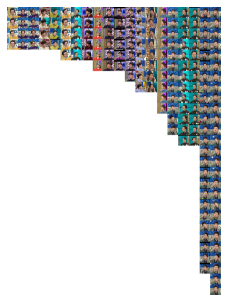

In [10]:
# 클러스터링(fingerprints) 후 결과 출력
clusters = calc.cluster(fingerprints, sim=0.63, min_csize=4) # the higher, the stricter

postproc.make_links(clusters, os.path.join(result_dir, 'imagecluster/clusters'))

images = icio.read_images(result_dir, size=(224,224))

fig, ax = postproc.plot_clusters(clusters, images)
fig.savefig(os.path.join(result_dir, 'imagecluster/_cluster.png'))
postproc.plt.show()

cluster dir: /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth/imagecluster/merged_clusters
plot array (uint8) size: 132.64453125 MiB


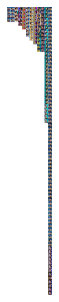

In [11]:
# After merging
FACE_THRESHOLD_HARD = 0.18
CLOTH_THRESHOLD_HARD = 0.12
merged_clusters = postproc.merge_clusters(clusters, fingerprints, FACE_THRESHOLD_HARD, CLOTH_THRESHOLD_HARD, iteration=1)

postproc.make_links(merged_clusters, os.path.join(result_dir, 'imagecluster/merged_clusters'))

images = icio.read_images(result_dir, size=(224,224))

fig, ax = postproc.plot_clusters(merged_clusters, images)
fig.savefig(os.path.join(result_dir, 'imagecluster/_merged_cluster.png'))
postproc.plt.show()